Loading Data....
./config/train/FIT/002_main_shell.yml
./config/train/FIT/002_main_shell.yml


/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/cobot_aae/src/datasets/render_fit_dataset.py:123: RuntimeWarning: invalid value encountered in true_divide
  shift = (shift - self.lb_shift)/(self.ub_shift - self.lb_shift)  # normalize to [0, 1]
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desire

Let's use 2 GPUs!


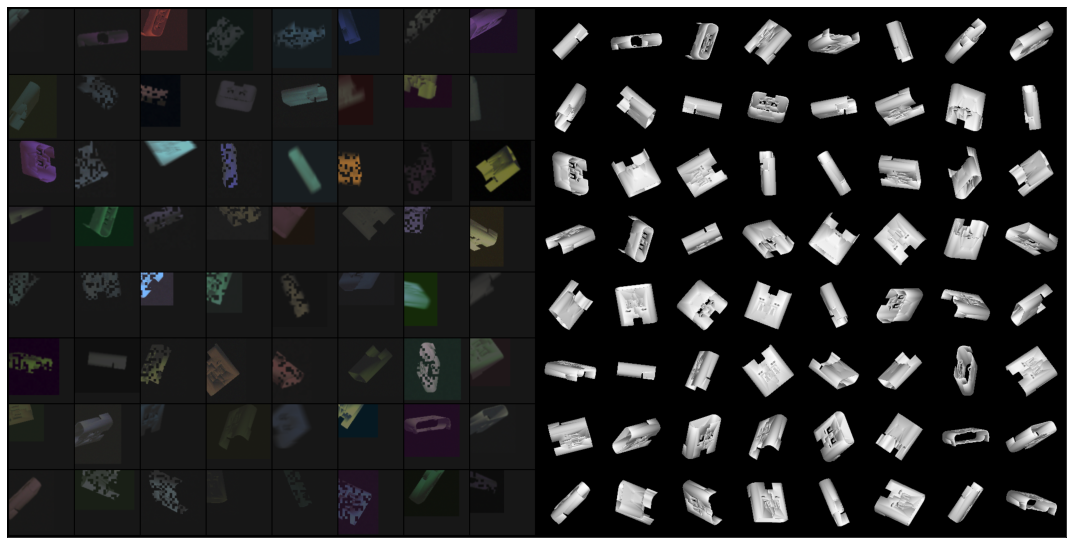

In [4]:
import contextlib
import sys
import warnings
import argparse

import gin
from tqdm import tqdm

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    from torch.utils.data import DataLoader
    from torchvision.transforms import functional as T
    from src.aae.models import AugmentedAutoEncoder
    from src.aae.utils import get_path_to_config
    from src.aae.Visualizations import plot_batch, plot_img
    from src.datasets.render_fit_dataset import *
    from src.datasets.concat_dataset import ConcatDataset
    from src.ycb_render.fit_renderer_tensor import *
    from src.config.config import cfg, cfg_from_file, get_output_dir, write_selected_class_file

class InfiniteIter:
    """
    Custom iterator that infinitely loops over a DataLoader
    """
    def __init__(self, dataloader):
        self.__dict__.update(vars())
        self.__reset__()
        
    def __iter__(self):
        return self

    def __reset__(self):
        self.dataIter = iter(self.dataloader)
    
    def __next__(self, size):
        try:
            data = next(self.dataIter)
        except StopIteration:
            self.__reset__()
            data = next(self.dataIter)
            
        if data.size(0) < size:
            self.__reset__()
            data = next(self.dataIter)
        elif data.size(0) > size:
            return data[:size]
        return data

class DummyFile(object):
    def write(self, x): 
        pass

    def flush(self):
        pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout
    

@gin.configurable
def train_aae(dis_dir:     str=gin.REQUIRED,
                renderer:    torch.utils.data.Dataset=gin.REQUIRED,
                cfg_file:    str=gin.REQUIRED,
                im_dim:      int=gin.REQUIRED,
                im_scale:  float=gin.REQUIRED,
                model_path:  str=gin.REQUIRED,
                num_workers: int=gin.REQUIRED,
                num_train_iters: int=gin.REQUIRED,
                cache_save_interval: int=gin.REQUIRED,
                batch_size: int=gin.REQUIRED,
                device: str=gin.REQUIRED):
    
    print("Loading Data....")
    print(cfg_file)
    
    # cfg_file = '.' + cfg_file
    print(cfg_file)
    # cfg_file = get_path_to_config(cfg_file)
    cfg_from_file(cfg_file)
    cfg.MODE = 'TRAIN'
    cfg.TRAIN.RENDER_SZ = im_dim
    cfg.TRAIN.INPUT_IM_SIZE = [im_dim, im_dim]

    cfg.TRAIN.ROI_CENTER_RANGE = [0, 0, im_dim // 2, im_dim // 2]
    cfg.TRAIN.ROI_SIZE_RANGE   = [im_dim * (1 - im_scale), im_dim * (1 + im_scale)]
    
    with nostdout(): 
        # augmented dataset
        dataset_train = renderer(model_path, cfg.TRAIN.OBJECTS,
                                                 render_size=cfg.TRAIN.RENDER_SZ,
                                                 output_size=cfg.TRAIN.INPUT_IM_SIZE)

    # real image background dataset
    dataset_dis = DistractorDataset(dis_dir, cfg.TRAIN.CHM_RAND_LEVEL,
                                    size_crop=(cfg.TRAIN.INPUT_IM_SIZE[1],
                                               cfg.TRAIN.INPUT_IM_SIZE[0]))
    
    
    dl = DataLoader(dataset_train,
                   batch_size=batch_size,
                   shuffle=True,
                   num_workers=num_workers)

    bg_dl = InfiniteIter(DataLoader(dataset_dis,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=num_workers))


    def produce_augmented_data(data, bg_dl, device):
        
        im, target, _, mask, _, _, _, _, _, roi_affine, *_= data
        
        im         = im.to(device)
        target     = target.to(device)
        mask       = mask.to(device)
        roi_affine = roi_affine.to(device)
        
        grids  = F.affine_grid(roi_affine, im.size())
        images = F.grid_sample(im, grids)
        mask   = F.grid_sample(mask, grids)
        mask   = 1 - mask
        

        cur_batch_sz    = images.size(0)
        bg              = bg_dl.__next__(cur_batch_sz).to(device)
        imdisp          = images + (mask * bg[:cur_batch_sz])
        noise_level     = np.random.uniform(0, 0.05)
        imdisp          += torch.randn_like(imdisp) * noise_level
        imdisp = images
        
        return (imdisp, target)
    
    fixed_data = produce_augmented_data(next(iter(dl)), bg_dl, device)
        
    model = AugmentedAutoEncoder(fixed_batch=fixed_data)
    model = model.to(device)
    cache_save_interval = 2

    ######################################
    # Generate Image of the current batch  
    ######################################
    rend = next(iter(dl))
    data = produce_augmented_data(rend, bg_dl, device)
    img_reel = model.produce_img_reel(data).permute(1,2,0).cpu().numpy()
    return img_reel


def parse_args():
    """
    parse input arguments
    """
    parser = argparse.ArgumentParser(description='train aae model for a certain object from FIT parts')
    parser.add_argument('--gin_cfg_dir', dest='gin_cfg_dir',
                        help='directory for configuration file',
                        required=True, type=str)
    
    args = parser.parse_args()
    return args

if __name__ == '__main__':
    # args = parse_args()
    gin.enter_interactive_mode()
    gin.parse_config_file('./config/train/FIT/train_main_shell.gin')
    # gin.parse_config_file('./config/train/FIT/train_top_shell.gin')
    # gin.parse_config_file('./config/train/FIT/train_insert_mold.gin')
    data_reel = train_aae()

    plot_img(data_reel)